#### **Quality Control (QC) of MRI processing pipelines.**

Quality control in neuroimaging is a mandatory steps before moving on to statistical analysis. The usual approach often relies on performing visual inspection of the pipeline's results. However, when dealing with big data studies (such as the present one), visually inspecting all the subject's results is simply not possible. Therefore, this notebook will perform automated QC of various pipeline results; notably the subcortical and cortical segmentations, the quality of the final tractogram, and functional connectivity matrices using statistical methods. 

As a general guideline, we opted for classic statistical removal of outliers. For each pipeline results we assessed, we computed the inter-quartile range (IQR), and systematically removed subjects with values over or under the 5 * IQR threshold. Modalities are processed in this order:

1. **sMRI** (Subcortical and cortical segmentations results)

Running this notebook will output filtered dataframes as well as publication-ready figures showing the distribution, IQR, and outliers of the assessed metrics.

**Some cells contain long running processes, they will be identified by this commented line at the beginning of the cell:** \
`# ** This a long running process, got grab a coffee ! **`

In [1]:
# Imports
import os

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager
import numpy as np
import seaborn as sns

In [31]:
# Setting up data and output paths.
repository_dir = "~/code/Gagnon_BrainAge_2025/"
data_abcd = "/Volumes/T7/BrainProfilesAssociations/ABCD/"
output_folder = "/Volumes/T7/BrainAgeStudy/"

# Create output folder if it doesn't exist.
output_dir = f"{output_folder}/QC/"
os.makedirs(output_dir, exist_ok=True)

# Create an empty list of IDs to exclude.
ids_to_exclude = []

In [3]:
# Fetch Harding font.
font_files = []
for fontpath in font_manager.findSystemFonts(fontpaths=None, fontext='ttf'):
    if "Harding".lower() in fontpath.lower():
        font_files.append(fontpath)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# Set Harding font.
plt.rcParams['font.family'] = 'Harding Text Web'

#### **ABCD Cohort: QC and visualization of anatomical metrics of cortical and sub-cortical ROIs.**

The following cells will inspect results from the subcortical and cortical segmentations performed using the Brainnetome Child Atlas [[1]](#1). Specifically, volume, area and cortical thickness distributions will be plotted and IQR extracted. Subjects with values over or under 3 * IQR will be systematically removed and append into a text file. The initial segmentation was performed using FastSurfer [[2]](#2) and Brainnetome child atlas [[1]](#1) was moved into subject's space using surface-based registration. The following cells assume the subcortical and cortical data have been gathered within a csv-like file. If not, please see the [asegstats2table](https://surfer.nmr.mgh.harvard.edu/fswiki/asegstats2table) and/or [aparcstats2table](https://surfer.nmr.mgh.harvard.edu/fswiki/aparcstats2table) from the FreeSurfer documentation to learn how to extract the values from raw FastSurfer/FreeSurfer outputs.

**Some variables name are reused between cohorts to avoid high memory consumption. Therefore, if you want to run only specific cell, it would be a good practice to run all the previous cells for this specific cohort.**

**References** \
<a id=#1>[1]</a> Li, W., Fan, L., Shi, W., Lu, Y., Li, J., Luo, N., Wang, H., Chu, C., Ma, L., Song, M., Li, K., Cheng, L., Cao, L., & Jiang, T. (2023). Brainnetome atlas of preadolescent children based on anatomical connectivity profiles. Cerebral Cortex, 33(9), 5264–5275. https://doi.org/10.1093/cercor/bhac415 \
<a id=#2>[2]</a> Henschel, L., Conjeti, S., Estrada, S., Diers, K., Fischl, B., & Reuter, M. (2020). FastSurfer—A fast and accurate deep learning based neuroimaging pipeline. NeuroImage, 219, 117012. https://doi.org/10.1016/j.neuroimage.2020.117012

In [32]:
# Load subcortical data.
subcortical_df = pd.read_csv(f"{data_abcd}/AnatomicalStats/subcortical_volumes.tsv", sep="\t")
subcortical_df.columns = subcortical_df.columns.str.replace("Sample", "subjectkey")

# Print the number of subjects and number of ROIs.
subs, rois = subcortical_df.shape
print(f"Number of subjects: {subs}")
print(f"Number of ROIs: {rois - 1}") # Excluding the subject ID column.

# Filter out subjects with all 0 values for all ROIs and print their IDs.
zero_subs = subcortical_df[subcortical_df.iloc[:, 1:].sum(axis=1) == 0]
zero_subs_ids = zero_subs["subjectkey"].to_list()
print(f"Number of subjects with 0 values for all ROIs: {len(zero_subs_ids)}")
print(f"IDs of subjects with 0 values for all ROIs: {zero_subs_ids}")

# Drop subjects with all 0 values for all ROIs.
subcortical_df = subcortical_df[subcortical_df.iloc[:, 1:].sum(axis=1) != 0]
subcortical_df.reset_index(inplace=True, drop=True)

Number of subjects: 9272
Number of ROIs: 39
Number of subjects with 0 values for all ROIs: 0
IDs of subjects with 0 values for all ROIs: []


/var/folders/23/p0fh1nrd473dtfz3cx_4g0j00000gn/T/ipykernel_7909/1163275470.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels([roi.replace("_L", "") for roi in left_hemisphere], fontsize=14)
/var/folders/23/p0fh1nrd473dtfz3cx_4g0j00000gn/T/ipykernel_7909/1163275470.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels([roi.replace("_R", "") for roi in right_hemisphere], fontsize=14)


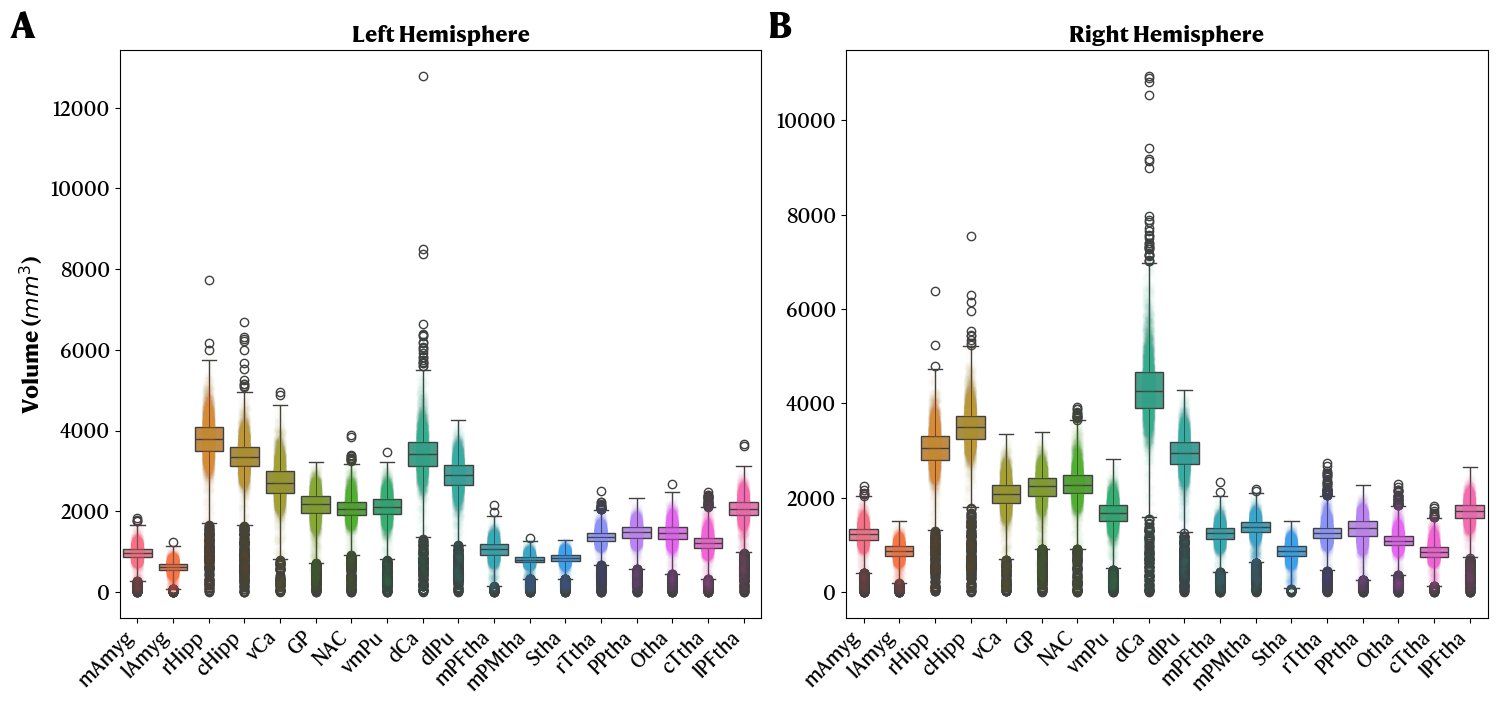

In [33]:
# Plotting the distribution of volumes for left and right hemispheres using a boxplot.
# Fetch left and right hemisphere ROIs.
left_hemisphere = [roi for roi in subcortical_df.columns if "L" in roi]
right_hemisphere = [roi for roi in subcortical_df.columns if "R" in roi]

# Plotting the distribution of volumes for left and right hemispheres using a boxplot.
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# Left hemisphere.
leftbox = sns.boxplot(data=subcortical_df[left_hemisphere], ax=ax[0], whis=3)
sns.stripplot(data=subcortical_df[left_hemisphere], ax=ax[0], alpha=0.01, palette="husl")
ax[0].set_title("Left Hemisphere", fontsize=16, fontweight='bold')
ax[0].set_ylabel("Volume ($mm^3$)", fontsize=16, fontweight='bold')
ax[0].set_xticklabels([roi.replace("_L", "") for roi in left_hemisphere], fontsize=14)
ax[0].figure.autofmt_xdate(rotation=45, ha='right')
ax[0].tick_params(axis='y', labelsize=14)

# Right hemisphere.
rightbox = sns.boxplot(data=subcortical_df[right_hemisphere], ax=ax[1], whis=3)
sns.stripplot(data=subcortical_df[right_hemisphere], ax=ax[1], alpha=0.01, palette="husl")
ax[1].set_title("Right Hemisphere", fontsize=16, fontweight='bold')
ax[1].set_xticklabels([roi.replace("_R", "") for roi in right_hemisphere], fontsize=14)
ax[1].figure.autofmt_xdate(rotation=45, ha='right')
ax[1].tick_params(axis='y', labelsize=14)

txt = r"$\bf{"+str("Figure\ 1.")+"}$" + "Distribution of subcortical volumes for left and right hemispheres for each ROIs in the ABCD cohort. For visualization purposes, only the subjects with 5 * IQR range are labeled. Final outlier removal will remove subjects with 3 * IQR range. " + \
        r"$\bf{"+str("A.\ ")+"}$" + "Left Hemisphere. " + \
        r"$\bf{"+str("B.\ ")+"}$" + "Right Hemisphere."
#plt.figtext(0.5, -0.025, txt, wrap=True, horizontalalignment='center', fontsize=14)

# Add label to subplots.
plt.gcf().text(0.005, 0.96, "A", fontsize=26, fontweight='bold')
plt.gcf().text(0.51, 0.96, "B", fontsize=26, fontweight='bold')

# Save the plot.
plt.tight_layout()
plt.savefig(f"{output_dir}/ABCD_subcortical_volumes_boxplot.png", dpi=300, bbox_inches='tight')

In [34]:
# Check for NaNs in the data and save the IDs of subjects with NaNs.
nan_counts = subcortical_df.isna().sum()
nan_counts = nan_counts[nan_counts > 0]
print(f"Number of NaNs in the data: {nan_counts.sum()}")
nan_subs = subcortical_df[subcortical_df.isna().any(axis=1)]
nan_subs_ids = nan_subs["subjectkey"].to_list()
print(f"IDs of subjects with NaNs: {nan_subs_ids}")

# Dropping rows with NaNs.
subcortical_df.dropna(axis=0, inplace=True)

ids_to_exclude.extend(nan_subs_ids)

Number of NaNs in the data: 13
IDs of subjects with NaNs: ['sub-NDARINVH1U9GLWT']


In [35]:
# Fetching the ID labels for the subjects with volumes outside the 3 * IQR range for all ROIs.
iqr = []
for roi in subcortical_df.columns[1:]:
    q75, q25 = np.quantile(subcortical_df[roi].values, [.75, .25])
    intr_qr = q75 - q25 
    qmax = q75 + (5 * intr_qr)
    qmin = q25 - (5 * intr_qr)
    iqr.append([qmin, qmax])

# Add subject id to points outside the 3 * IQR range for all ROIs.
ids = []
for i, roi in enumerate(subcortical_df.columns[1:]):
    for j, val in enumerate(subcortical_df[roi]):
        if val < iqr[i][0] or val > iqr[i][1]:
            ids.append(subcortical_df["subjectkey"][j])

# Combine with the IDs of subjects with NaNs and 0 values for all ROIs.
ids.extend(nan_subs_ids)

# Print the IDs of the subjects with volumes outside the 3 * IQR range for all ROIs.
print(f"Number of subjects with volumes outside the 5 * IQR range for all ROIs: {len(np.unique(ids))}")

# Remove subjects with volumes outside the 3 * IQR range for all ROIs.
subcortical_df_QCed = subcortical_df[~subcortical_df["subjectkey"].isin(ids)]
subcortical_df_QCed.reset_index(inplace=True, drop=True)
print(f"Number of subjects after removing subjects with volumes outside the 5 * IQR range for all ROIs: {subcortical_df_QCed.shape[0]}")

# Save the cleaned subcortical data.
subcortical_df_QCed.to_csv(f"{output_dir}/ABCD_subcortical_volumes_QCed.csv", index=False, header=True)

ids_to_exclude.extend(ids)

Number of subjects with volumes outside the 5 * IQR range for all ROIs: 140
Number of subjects after removing subjects with volumes outside the 5 * IQR range for all ROIs: 9132


/var/folders/23/p0fh1nrd473dtfz3cx_4g0j00000gn/T/ipykernel_7909/510829328.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels([roi.replace("_L", "") for roi in left_hemisphere], fontsize=14)
/var/folders/23/p0fh1nrd473dtfz3cx_4g0j00000gn/T/ipykernel_7909/510829328.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels([roi.replace("_R", "") for roi in right_hemisphere], fontsize=14)


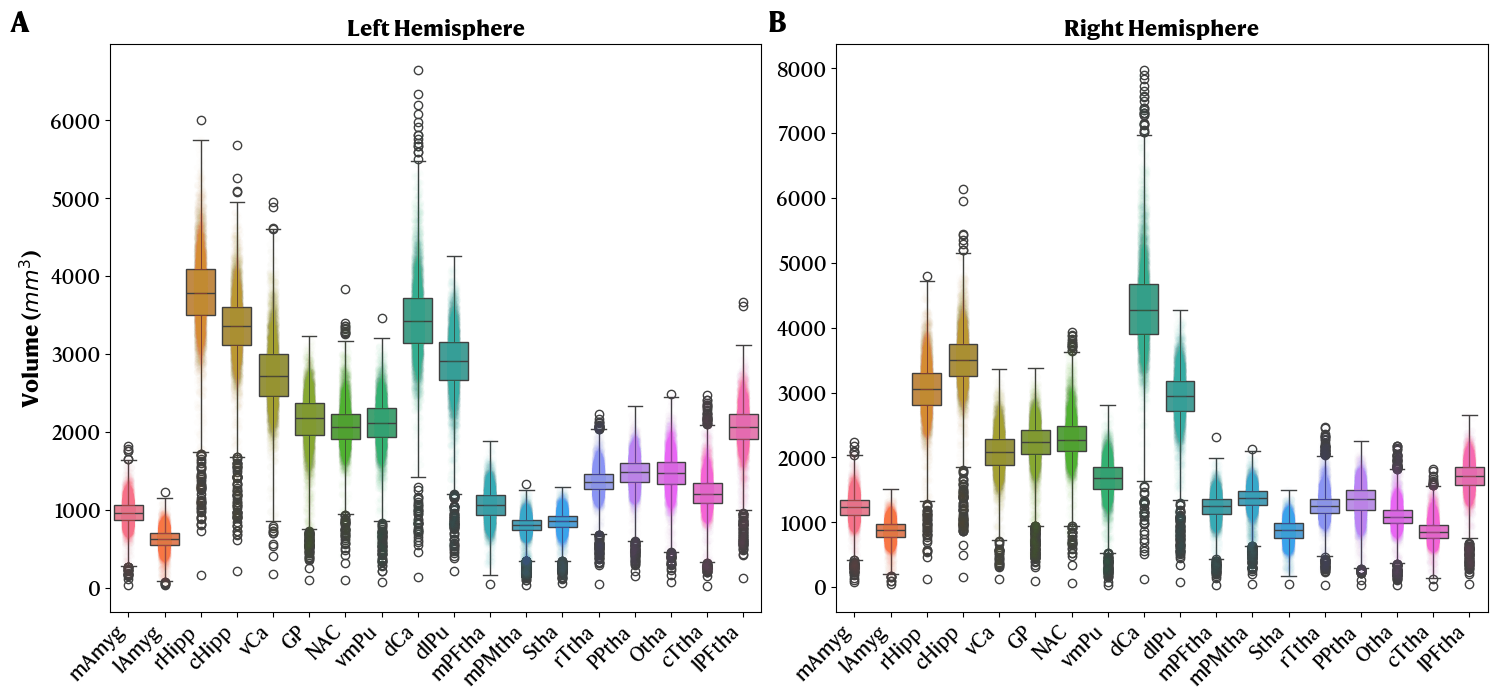

In [36]:
# Plotting the distribution of volumes for left and right hemispheres using a boxplot.

fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# Left hemisphere.
leftbox = sns.boxplot(data=subcortical_df_QCed[left_hemisphere], ax=ax[0], whis=3)
sns.stripplot(data=subcortical_df_QCed[left_hemisphere], ax=ax[0], alpha=0.01, palette="husl")
ax[0].set_title("Left Hemisphere", fontsize=16, fontweight='bold')
ax[0].set_ylabel("Volume ($mm^3$)", fontsize=16, fontweight='bold')
ax[0].set_xticklabels([roi.replace("_L", "") for roi in left_hemisphere], fontsize=14)
ax[0].figure.autofmt_xdate(rotation=45, ha='right')
ax[0].tick_params(axis='y', labelsize=14)

# Right hemisphere.
rightbox = sns.boxplot(data=subcortical_df_QCed[right_hemisphere], ax=ax[1], whis=3)
sns.stripplot(data=subcortical_df_QCed[right_hemisphere], ax=ax[1], alpha=0.01, palette="husl")
ax[1].set_title("Right Hemisphere", fontsize=16, fontweight='bold')
ax[1].set_xticklabels([roi.replace("_R", "") for roi in right_hemisphere], fontsize=14)
ax[1].figure.autofmt_xdate(rotation=45, ha='right')
ax[1].tick_params(axis='y', labelsize=14)

txt = r"$\bf{"+str("Figure\ 2.")+"}$" + "Distribution of subcortical volumes for left and right hemispheres for each ROIs after outlier removal (subjects with values over or under 5 * IQR range) in the ABCD cohort. " + \
        r"$\bf{"+str("A.\ ")+"}$" + "Left Hemisphere. " + \
        r"$\bf{"+str("B.\ ")+"}$" + "Right Hemisphere."
#plt.figtext(0.5, -0.025, txt, wrap=True, horizontalalignment='center', fontsize=14)

# Add label to subplots.
plt.gcf().text(0.005, 0.96, "A", fontsize=20, fontweight='bold')
plt.gcf().text(0.51, 0.96, "B", fontsize=20, fontweight='bold')

# Save the plot.
plt.tight_layout()
plt.savefig(f"{output_dir}/ABCD_subcortical_volumes_boxplot_QCed.png", dpi=300, bbox_inches='tight')

In [37]:
# Load cortical data.
thickness_df = pd.read_csv(f"{data_abcd}/AnatomicalStats/cortical_thickness_lh.tsv", sep="\t")
thickness_df.columns = thickness_df.columns.str.replace("Sample", "subjectkey")
volume_df = pd.read_csv(f"{data_abcd}/AnatomicalStats/cortical_volume_lh.tsv", sep="\t")
volume_df.columns = volume_df.columns.str.replace("Sample", "subjectkey")
area_df = pd.read_csv(f"{data_abcd}/AnatomicalStats/cortical_area_lh.tsv", sep="\t")
area_df.columns = area_df.columns.str.replace("Sample", "subjectkey")

# Filter out subjects with all 0 values for all ROIs and print their IDs.
zero_subs = thickness_df[thickness_df.iloc[:, 1:].sum(axis=1) == 0]
zero_subs_ids = zero_subs["subjectkey"].to_list()
print(f"Number of subjects with 0 values for all ROIs in thickness data: {len(zero_subs_ids)}")
print(f"IDs of subjects with 0 values for all ROIs in thickness data: {zero_subs_ids}")

zero_subs = volume_df[volume_df.iloc[:, 1:].sum(axis=1) == 0]
zero_subs_ids = zero_subs["subjectkey"].to_list()
print(f"Number of subjects with 0 values for all ROIs in volume data: {len(zero_subs_ids)}")
print(f"IDs of subjects with 0 values for all ROIs in volume data: {zero_subs_ids}")

zero_subs = area_df[area_df.iloc[:, 1:].sum(axis=1) == 0]
zero_subs_ids = zero_subs["subjectkey"].to_list()
print(f"Number of subjects with 0 values for all ROIs in area data: {len(zero_subs_ids)}")
print(f"IDs of subjects with 0 values for all ROIs in area data: {zero_subs_ids}")

# Drop subjects with all 0 values for all ROIs.
thickness_df = thickness_df[thickness_df.iloc[:, 1:].sum(axis=1) != 0]
thickness_df.reset_index(inplace=True, drop=True)

volume_df = volume_df[volume_df.iloc[:, 1:].sum(axis=1) != 0]
volume_df.reset_index(inplace=True, drop=True)

area_df = area_df[area_df.iloc[:, 1:].sum(axis=1) != 0]
area_df.reset_index(inplace=True, drop=True)

# Replace column names with clean ROI names.
rois = [roi.replace("lh_", "") for roi in thickness_df.columns[1:]]
rois = [roi.replace("_thickness", "") for roi in rois]

thickness_df.columns = ["subjectkey"] + rois
volume_df.columns = ["subjectkey"] + rois
area_df.columns = ["subjectkey"] + rois

# Print the number of subjects and number of ROIs.
subs, rois = thickness_df.shape
print(f"Number of subjects in thickness data: {subs}")
print(f"Number of ROIs in thickness data: {rois - 1}") # Excluding the subject ID column.

subs, rois = volume_df.shape
print(f"Number of subjects in volume data: {subs}")
print(f"Number of ROIs in volume data: {rois - 1}") # Excluding the subject ID column.

subs, rois = area_df.shape
print(f"Number of subjects in area data: {subs}")
print(f"Number of ROIs in area data: {rois - 1}") # Excluding the subject ID column.

Number of subjects with 0 values for all ROIs in thickness data: 0
IDs of subjects with 0 values for all ROIs in thickness data: []
Number of subjects with 0 values for all ROIs in volume data: 0
IDs of subjects with 0 values for all ROIs in volume data: []
Number of subjects with 0 values for all ROIs in area data: 0
IDs of subjects with 0 values for all ROIs in area data: []
Number of subjects in thickness data: 9272
Number of ROIs in thickness data: 94
Number of subjects in volume data: 9272
Number of ROIs in volume data: 94
Number of subjects in area data: 9272
Number of ROIs in area data: 94


In [38]:
# Check for NaNs in the data and save the IDs of subjects with NaNs.
nan_subs_ids = []
for df, name in zip([thickness_df, volume_df, area_df], ["thickness", "volume", "area"]):
    nan_counts = df.isna().sum()
    nan_counts = nan_counts[nan_counts > 0]
    print(f"Number of NaNs in {name} data: {nan_counts.sum()}")
    nan_subs = df[df.isna().any(axis=1)]
    if nan_subs_ids == []:
        nan_subs_ids = nan_subs["subjectkey"].to_list()
    else:
        nan_subs_ids = nan_subs_ids.extend(nan_subs["subjectkey"].to_list())
    # Drop rows with NaNs.
    df.dropna(axis=0, inplace=True)
    print(f"IDs of subjects with NaNs in {name} data: {nan_subs_ids}")

ids_to_exclude.extend(nan_subs_ids)

Number of NaNs in thickness data: 0
IDs of subjects with NaNs in thickness data: []
Number of NaNs in volume data: 0
IDs of subjects with NaNs in volume data: []
Number of NaNs in area data: 0
IDs of subjects with NaNs in area data: []


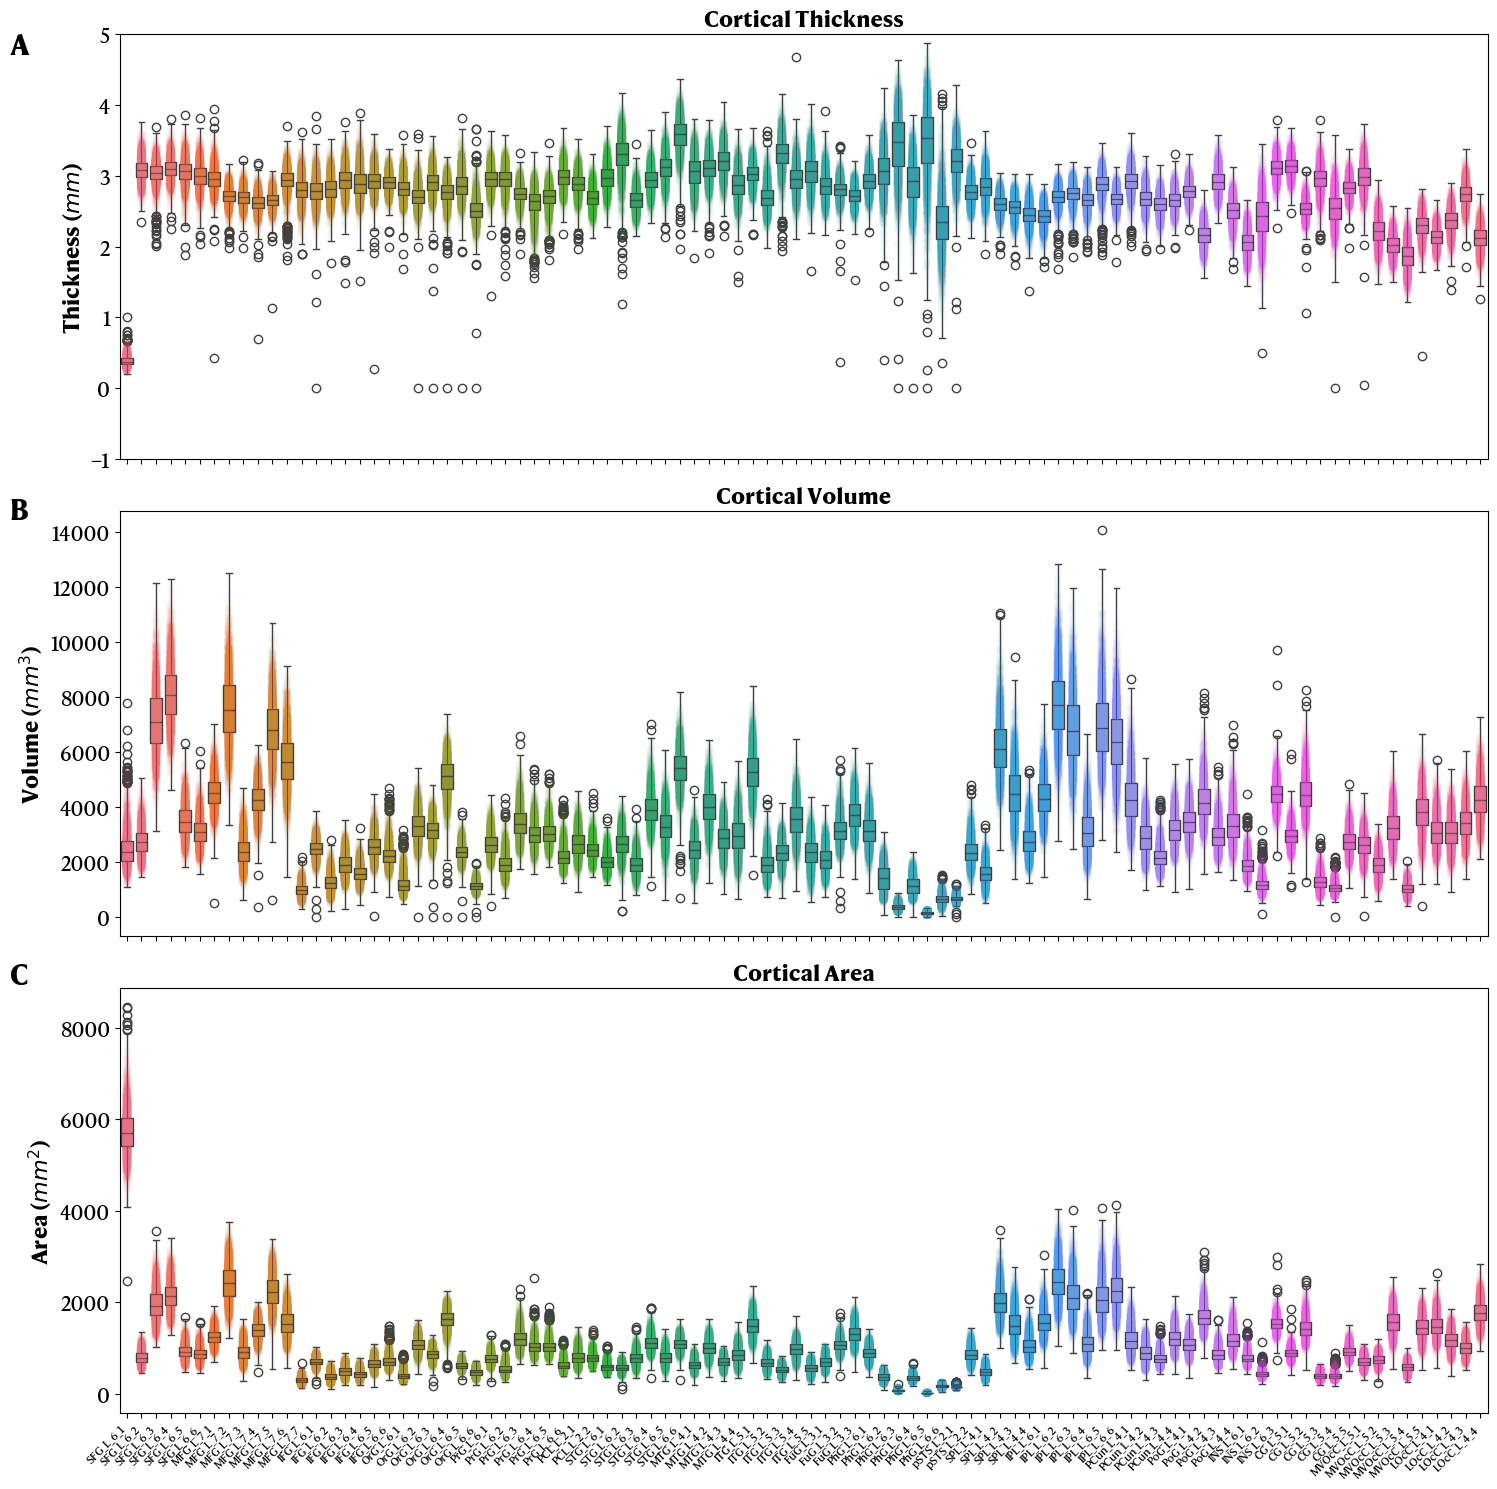

In [22]:
# Plotting the distribution of thickness, volume and area for left hemisphere using a boxplot.
fig, ax = plt.subplots(3, 1, figsize=(15, 15))

# Thickness.
thicknessbox = sns.boxplot(data=thickness_df.iloc[:, 1:], ax=ax[0], whis=3)
sns.stripplot(data=thickness_df.iloc[:, 1:], ax=ax[0], alpha=0.01, palette="husl")
ax[0].set_title("Cortical Thickness", fontsize=16, fontweight='bold')
ax[0].set_ylabel("Thickness ($mm$)", fontsize=16, fontweight='bold')
ax[0].figure.autofmt_xdate(rotation=45, ha='right')
ax[0].set_ylim(-1, 5)
ax[0].tick_params(axis='y', labelsize=14)

# Volume.
volumebox = sns.boxplot(data=volume_df.iloc[:, 1:], ax=ax[1], whis=3)
sns.stripplot(data=volume_df.iloc[:, 1:], ax=ax[1], alpha=0.01, palette="husl")
ax[1].set_title("Cortical Volume", fontsize=16, fontweight='bold')
ax[1].set_ylabel("Volume ($mm^3$)", fontsize=16, fontweight='bold')
ax[1].figure.autofmt_xdate(rotation=45, ha='right')
ax[1].tick_params(axis='y', labelsize=14)

# Area.
areabox = sns.boxplot(data=area_df.iloc[:, 1:], ax=ax[2], whis=3)
sns.stripplot(data=area_df.iloc[:, 1:], ax=ax[2], alpha=0.01, palette="husl")
ax[2].set_title("Cortical Area", fontsize=16, fontweight='bold')
ax[2].set_ylabel("Area ($mm^2$)", fontsize=16, fontweight='bold')
ax[2].figure.autofmt_xdate(rotation=45, ha='right')
ax[2].tick_params(axis='y', labelsize=14)
ax[2].tick_params(axis='x', labelsize=8)

txt = r"$\bf{"+str("Figure\ 3.")+"}$" + "Distribution of cortical thickness, volume and area for left hemisphere for each ROIs in the ABCD cohort. " + \
        "Final outlier removal will remove subjects with 5 * IQR range. " + \
        r"$\bf{"+"A."+"}$" + "Cortical Thickness. " + r"$\bf{"+"B."+"}$" + "Cortical Volume. " + r"$\bf{"+"C."+"}$" + "Cortical Area."

#plt.figtext(0.5, -0.015, txt, wrap=True, horizontalalignment='center', fontsize=12)

# Add label to subplots.
plt.gcf().text(0.005, 0.96, "A", fontsize=20, fontweight='bold')
plt.gcf().text(0.005, 0.65, "B", fontsize=20, fontweight='bold')
plt.gcf().text(0.005, 0.34, "C", fontsize=20, fontweight='bold')

# Save the plot.
plt.tight_layout()
plt.savefig(f"{output_dir}/ABCD_cortical_thickness_volume_area_boxplot_left_hemi.png", dpi=300, bbox_inches='tight')


In [39]:
# Fetching the ID labels for the subjects with volumes outside the 5 * IQR range for all ROIs.
iqr = []
for roi in thickness_df.columns[1:]:
    q75, q25 = np.percentile(thickness_df[roi], [75, 25])
    intr_qr = q75 - q25
    qmax = q75 + (5 * intr_qr)
    qmin = q25 - (5 * intr_qr)
    iqr.append([qmin, qmax])

# Add subject id to points outside the 5 * IQR range for all ROIs.
thick_ids = []
for i, roi in enumerate(thickness_df.columns[1:]):
    for j, val in enumerate(thickness_df[roi]):
        if val < iqr[i][0] or val > iqr[i][1]:
            thick_ids.append(thickness_df["subjectkey"][j])

# Print the IDs of the subjects with volumes outside the 5 * IQR range for all ROIs.
print(f"Number of subjects with volumes outside the 5 * IQR range for all ROIs in thickness data: {len(np.unique(thick_ids))}")

# Remove subjects with volumes outside the 5 * IQR range for all ROIs.
thickness_df_QCed = thickness_df[~thickness_df["subjectkey"].isin(thick_ids)]
thickness_df_QCed.reset_index(inplace=True, drop=True)
print(f"Number of subjects after removing subjects with volumes outside the 5 * IQR range for all ROIs in thickness data: {thickness_df_QCed.shape[0]}")

# Save the cleaned thickness data.
thickness_df_QCed.to_csv(f"{output_dir}/ABCD_left_cortical_thickness_QCed.csv", index=False, header=True)

ids_to_exclude.extend(thick_ids)

# Fetching the ID labels for the subjects with volumes outside the 5 * IQR range for all ROIs.  
iqr = []
for roi in volume_df.columns[1:]:
    q75, q25 = np.percentile(volume_df[roi], [75, 25])
    intr_qr = q75 - q25
    qmax = q75 + (5 * intr_qr)
    qmin = q25 - (5 * intr_qr)
    iqr.append([qmin, qmax])

# Add subject id to points outside the 5 * IQR range for all ROIs.
vol_ids = []
for i, roi in enumerate(volume_df.columns[1:]):
    for j, val in enumerate(volume_df[roi]):
        if val < iqr[i][0] or val > iqr[i][1]:
            vol_ids.append(volume_df["subjectkey"][j])

# Print the IDs of the subjects with volumes outside the 5 * IQR range for all ROIs.
print(f"Number of subjects with volumes outside the 5 * IQR range for all ROIs in volume data: {len(np.unique(vol_ids))}")

# Remove subjects with volumes outside the 5 * IQR range for all ROIs.
volume_df_QCed = volume_df[~volume_df["subjectkey"].isin(vol_ids)]
volume_df_QCed.reset_index(inplace=True, drop=True)
print(f"Number of subjects after removing subjects with volumes outside the 5 * IQR range for all ROIs in volume data: {volume_df_QCed.shape[0]}")

# Save the cleaned volume data.
volume_df_QCed.to_csv(f"{output_dir}/ABCD_left_cortical_volume_QCed.csv", index=False, header=True)

ids_to_exclude.extend(vol_ids)

# Fetching the ID labels for the subjects with volumes outside the 5 * IQR range for all ROIs.
iqr = []
for roi in area_df.columns[1:]:
    q75, q25 = np.percentile(area_df[roi], [75, 25])
    intr_qr = q75 - q25
    qmax = q75 + (5 * intr_qr)
    qmin = q25 - (5 * intr_qr)
    iqr.append([qmin, qmax])

# Add subject id to points outside the 5 * IQR range for all ROIs.
area_ids = []
for i, roi in enumerate(area_df.columns[1:]):
    for j, val in enumerate(area_df[roi]):
        if val < iqr[i][0] or val > iqr[i][1]:
            area_ids.append(area_df["subjectkey"][j])

# Print the IDs of the subjects with volumes outside the 5 * IQR range for all ROIs.
print(f"Number of subjects with volumes outside the 5 * IQR range for all ROIs in area data: {len(np.unique(area_ids))}")

# Remove subjects with volumes outside the 5 * IQR range for all ROIs.
area_df_QCed = area_df[~area_df["subjectkey"].isin(area_ids)]
area_df_QCed.reset_index(inplace=True, drop=True)
print(f"Number of subjects after removing subjects with volumes outside the 5 * IQR range for all ROIs in area data: {area_df_QCed.shape[0]}")

# Save the cleaned area data.
area_df_QCed.to_csv(f"{output_dir}/ABCD_left_cortical_area_QCed.csv", index=False, header=True)

ids_to_exclude.extend(area_ids)

# Looking at similarities between the excluded subjects in thickness, volume and area data.
excluded_subs_left = set(thick_ids).union(set(vol_ids)).union(set(area_ids)).union(set(nan_subs_ids)).union(set(zero_subs_ids))
print(f"Number of subjects excluded in thickness, volume and area data: {len(excluded_subs_left)}")


Number of subjects with volumes outside the 5 * IQR range for all ROIs in thickness data: 18
Number of subjects after removing subjects with volumes outside the 5 * IQR range for all ROIs in thickness data: 9254
Number of subjects with volumes outside the 5 * IQR range for all ROIs in volume data: 7
Number of subjects after removing subjects with volumes outside the 5 * IQR range for all ROIs in volume data: 9265
Number of subjects with volumes outside the 5 * IQR range for all ROIs in area data: 6
Number of subjects after removing subjects with volumes outside the 5 * IQR range for all ROIs in area data: 9266
Number of subjects excluded in thickness, volume and area data: 28


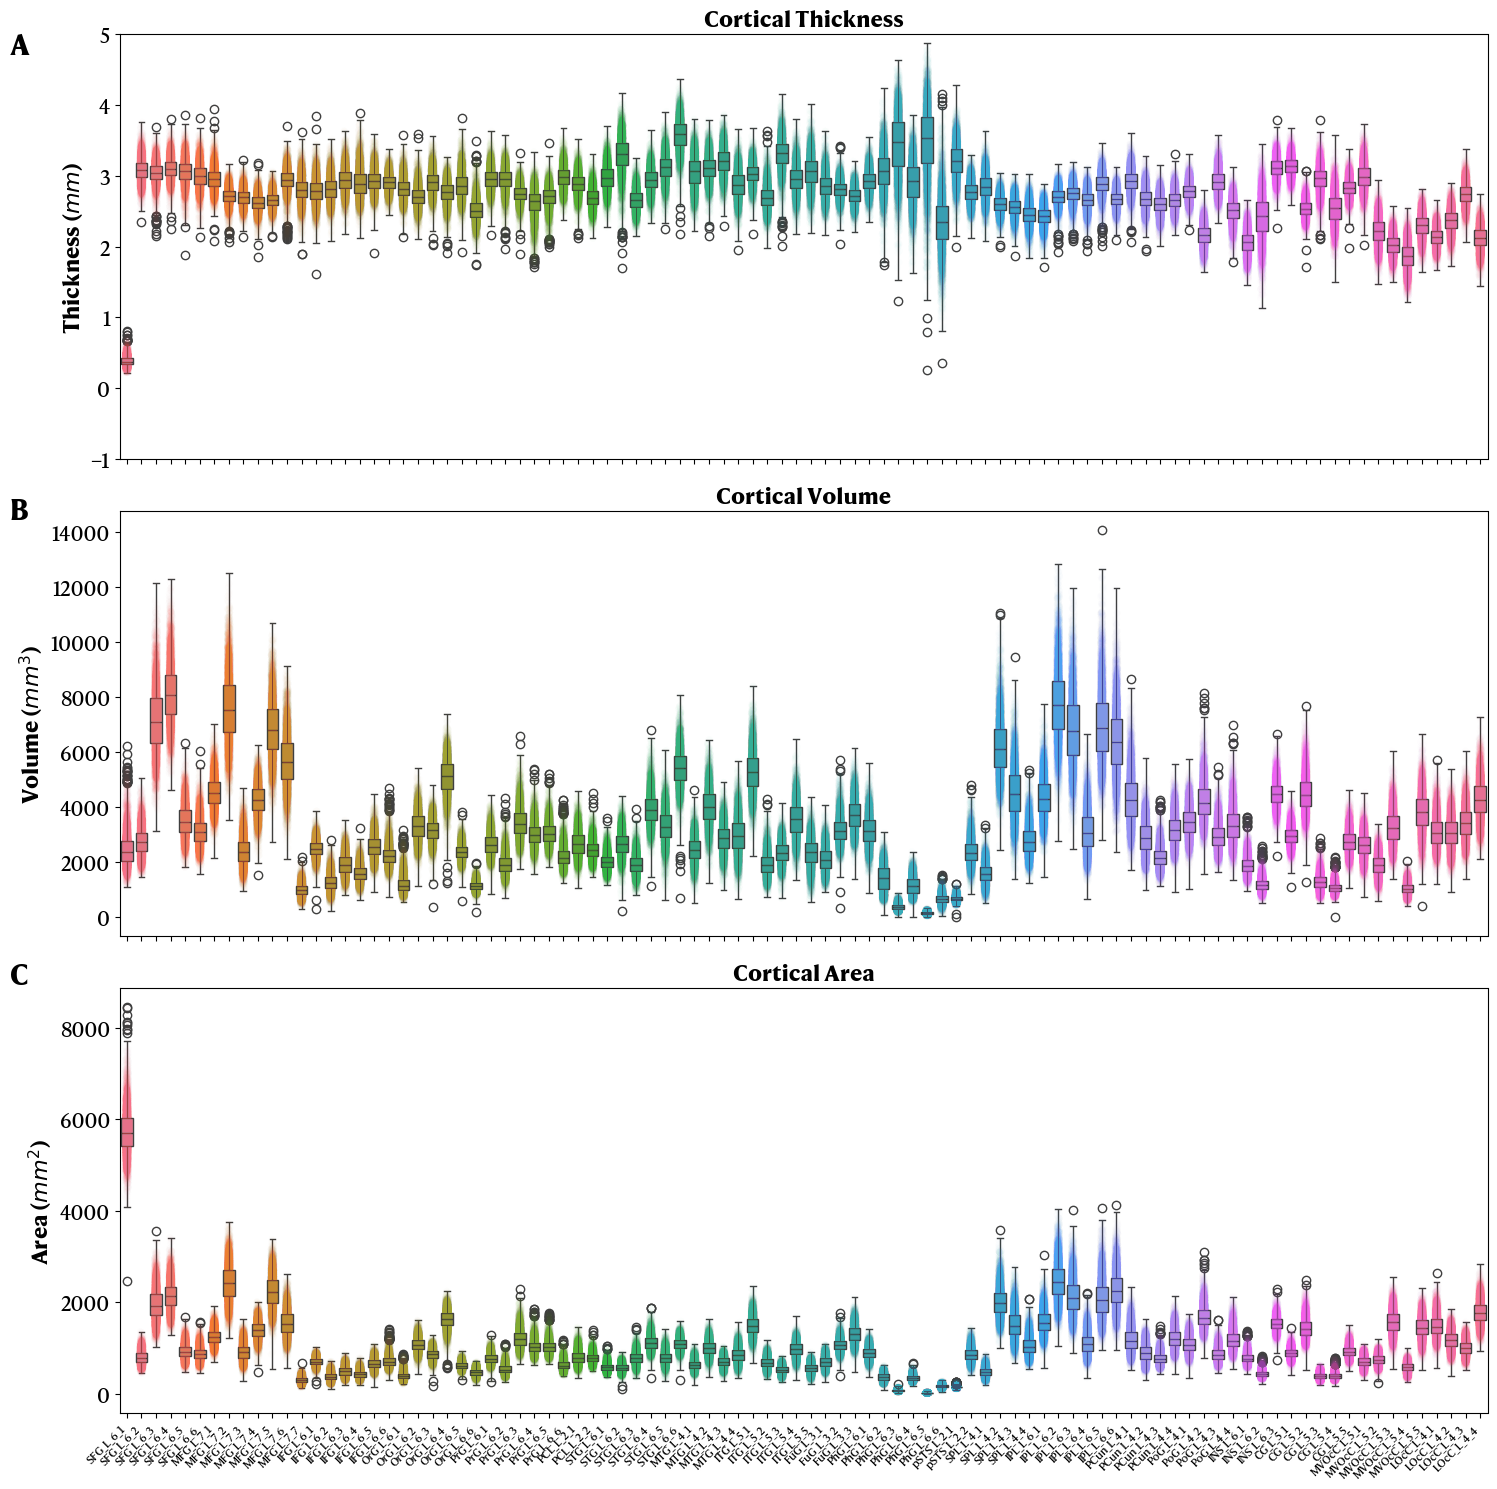

In [24]:
# Plotting the distribution of thickness, volume and area for left hemisphere using a boxplot after QC.

fig, ax = plt.subplots(3, 1, figsize=(15, 15))

# Thickness.
thicknessbox = sns.boxplot(data=thickness_df_QCed.iloc[:, 1:], ax=ax[0], whis=3)
sns.stripplot(data=thickness_df_QCed.iloc[:, 1:], ax=ax[0], alpha=0.01, palette="husl")
ax[0].set_title("Cortical Thickness", fontsize=16, fontweight='bold')
ax[0].set_ylabel("Thickness ($mm$)", fontsize=16, fontweight='bold')
ax[0].figure.autofmt_xdate(rotation=45, ha='right')
ax[0].set_ylim(-1, 5)
ax[0].tick_params(axis='y', labelsize=14)

# Volume.
volumebox = sns.boxplot(data=volume_df_QCed.iloc[:, 1:], ax=ax[1], whis=3)
sns.stripplot(data=volume_df_QCed.iloc[:, 1:], ax=ax[1], alpha=0.01, palette="husl")
ax[1].set_title("Cortical Volume", fontsize=16, fontweight='bold')
ax[1].set_ylabel("Volume ($mm^3$)", fontsize=16, fontweight='bold')
ax[1].figure.autofmt_xdate(rotation=45, ha='right')
ax[1].tick_params(axis='y', labelsize=14)

# Area.
areabox = sns.boxplot(data=area_df_QCed.iloc[:, 1:], ax=ax[2], whis=3)
sns.stripplot(data=area_df_QCed.iloc[:, 1:], ax=ax[2], alpha=0.01, palette="husl")
ax[2].set_title("Cortical Area", fontsize=16, fontweight='bold')
ax[2].set_ylabel("Area ($mm^2$)", fontsize=16, fontweight='bold')
ax[2].figure.autofmt_xdate(rotation=45, ha='right')
ax[2].tick_params(axis='y', labelsize=14)
ax[2].tick_params(axis='x', labelsize=8)

txt = r"$\bf{"+str("Figure\ 4.")+"}$" + "Distribution of cortical thickness, volume and area for left hemisphere for each ROIs after outlier removal (subjects with values over or under 5 * IQR range) in the ABCD cohort. " + \
        r"$\bf{"+"A."+"}$" + "Cortical Thickness. " + r"$\bf{"+"B."+"}$" + "Cortical Volume. " + r"$\bf{"+"C."+"}$" + "Cortical Area."

#plt.figtext(0.5, -0.015, txt, wrap=True, horizontalalignment='center', fontsize=12)

# Add label to subplots.
plt.gcf().text(0.005, 0.96, "A", fontsize=20, fontweight='bold')
plt.gcf().text(0.005, 0.65, "B", fontsize=20, fontweight='bold')
plt.gcf().text(0.005, 0.34, "C", fontsize=20, fontweight='bold')

# Save the plot.
plt.tight_layout()
plt.savefig(f"{output_dir}/ABCD_cortical_thickness_volume_area_boxplot_left_hemi_QCed.png", dpi=300, bbox_inches='tight')

In [40]:
# Load cortical data for the right hemisphere.
thickness_df = pd.read_csv(f"{data_abcd}/AnatomicalStats/cortical_thickness_rh.tsv", sep="\t")
thickness_df.columns = thickness_df.columns.str.replace("Sample", "subjectkey")
volume_df = pd.read_csv(f"{data_abcd}/AnatomicalStats/cortical_volume_rh.tsv", sep="\t")
volume_df.columns = volume_df.columns.str.replace("Sample", "subjectkey")
area_df = pd.read_csv(f"{data_abcd}/AnatomicalStats/cortical_area_rh.tsv", sep="\t")
area_df.columns = area_df.columns.str.replace("Sample", "subjectkey")

# Filter out subjects with all 0 values for all ROIs and print their IDs.
zero_subs = thickness_df[thickness_df.iloc[:, 1:].sum(axis=1) == 0]
zero_subs_ids = zero_subs["subjectkey"].to_list()
print(f"Number of subjects with 0 values for all ROIs in thickness data: {len(zero_subs_ids)}")
print(f"IDs of subjects with 0 values for all ROIs in thickness data: {zero_subs_ids}")

zero_subs = volume_df[volume_df.iloc[:, 1:].sum(axis=1) == 0]
zero_subs_ids = zero_subs["subjectkey"].to_list()
print(f"Number of subjects with 0 values for all ROIs in volume data: {len(zero_subs_ids)}")
print(f"IDs of subjects with 0 values for all ROIs in volume data: {zero_subs_ids}")

zero_subs = area_df[area_df.iloc[:, 1:].sum(axis=1) == 0]
zero_subs_ids = zero_subs["subjectkey"].to_list()
print(f"Number of subjects with 0 values for all ROIs in area data: {len(zero_subs_ids)}")
print(f"IDs of subjects with 0 values for all ROIs in area data: {zero_subs_ids}")

# Drop subjects with all 0 values for all ROIs.
thickness_df = thickness_df[thickness_df.iloc[:, 1:].sum(axis=1) != 0]
thickness_df.reset_index(inplace=True, drop=True)

volume_df = volume_df[volume_df.iloc[:, 1:].sum(axis=1) != 0]
volume_df.reset_index(inplace=True, drop=True)

area_df = area_df[area_df.iloc[:, 1:].sum(axis=1) != 0]
area_df.reset_index(inplace=True, drop=True)

# Replace column names with clean ROI names.
rois = [roi.replace("rh_", "") for roi in thickness_df.columns[1:]]
rois = [roi.replace("_thickness", "") for roi in rois]

thickness_df.columns = ["subjectkey"] + rois
volume_df.columns = ["subjectkey"] + rois
area_df.columns = ["subjectkey"] + rois

# Print the number of subjects and number of ROIs.
subs, rois = thickness_df.shape
print(f"Number of subjects in thickness data: {subs}")
print(f"Number of ROIs in thickness data: {rois - 1}") # Excluding the subject ID column.

subs, rois = volume_df.shape
print(f"Number of subjects in volume data: {subs}")
print(f"Number of ROIs in volume data: {rois - 1}") # Excluding the subject ID column.

subs, rois = area_df.shape
print(f"Number of subjects in area data: {subs}")
print(f"Number of ROIs in area data: {rois - 1}") # Excluding the subject ID column.


Number of subjects with 0 values for all ROIs in thickness data: 0
IDs of subjects with 0 values for all ROIs in thickness data: []
Number of subjects with 0 values for all ROIs in volume data: 0
IDs of subjects with 0 values for all ROIs in volume data: []
Number of subjects with 0 values for all ROIs in area data: 0
IDs of subjects with 0 values for all ROIs in area data: []
Number of subjects in thickness data: 9272
Number of ROIs in thickness data: 94
Number of subjects in volume data: 9272
Number of ROIs in volume data: 94
Number of subjects in area data: 9272
Number of ROIs in area data: 94


In [41]:
# Check for NaNs in the data and save the IDs of subjects with NaNs.
nan_subs_ids = []
for df, name in zip([thickness_df, volume_df, area_df], ["thickness", "volume", "area"]):
    nan_counts = df.isna().sum()
    nan_counts = nan_counts[nan_counts > 0]
    print(f"Number of NaNs in {name} data: {nan_counts.sum()}")
    nan_subs = df[df.isna().any(axis=1)]
    if nan_subs_ids == []:
        nan_subs_ids = nan_subs["subjectkey"].to_list()
    else:
        nan_subs_ids = nan_subs_ids.extend(nan_subs["subjectkey"].to_list())
    # Drop rows with NaNs.
    df.dropna(axis=0, inplace=True)
    print(f"IDs of subjects with NaNs in {name} data: {nan_subs_ids}")

ids_to_exclude.extend(nan_subs_ids)

Number of NaNs in thickness data: 0
IDs of subjects with NaNs in thickness data: []
Number of NaNs in volume data: 0
IDs of subjects with NaNs in volume data: []
Number of NaNs in area data: 0
IDs of subjects with NaNs in area data: []


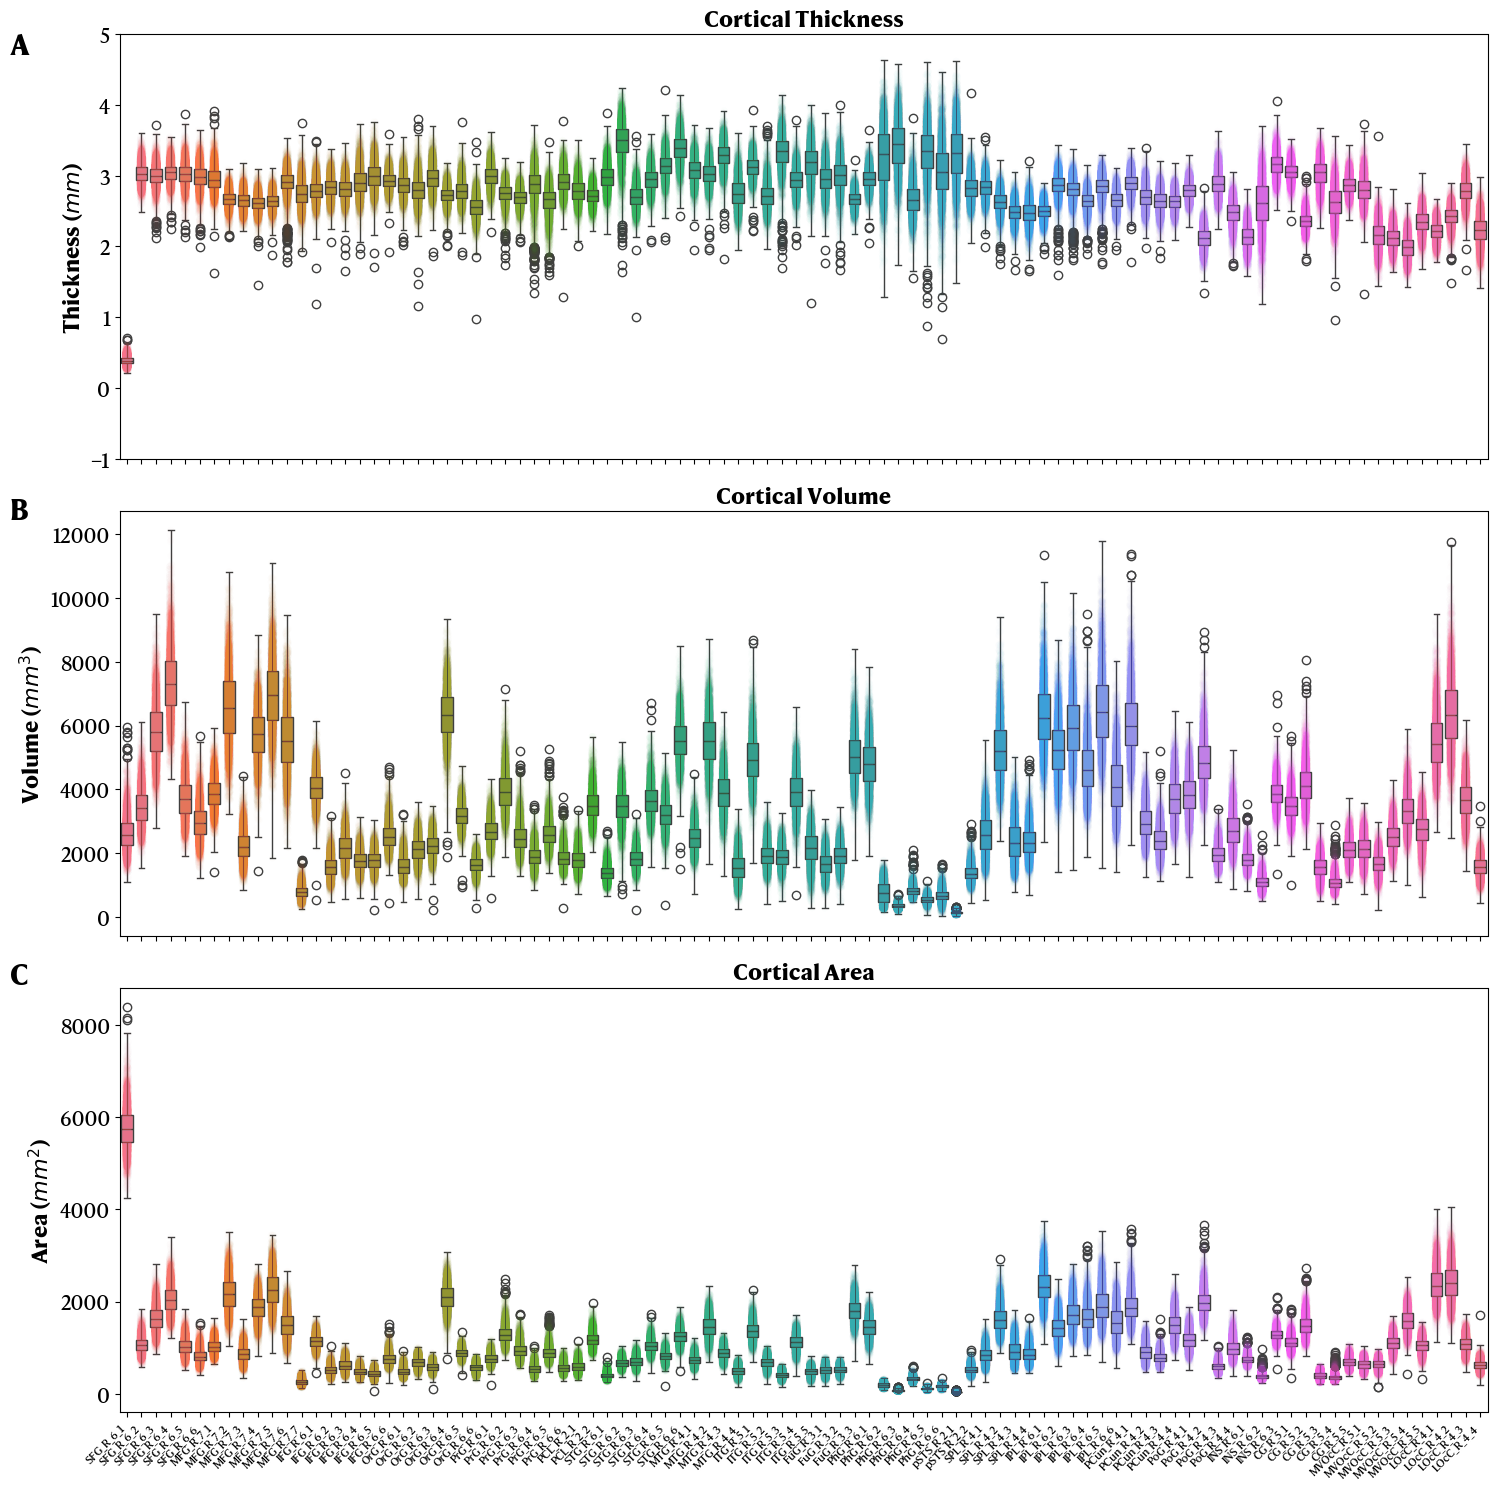

In [27]:
# Plotting the distribution of thickness, volume and area for right hemisphere using a boxplot.

fig, ax = plt.subplots(3, 1, figsize=(15, 15))

# Thickness.
thicknessbox = sns.boxplot(data=thickness_df.iloc[:, 1:], ax=ax[0], whis=3)
sns.stripplot(data=thickness_df.iloc[:, 1:], ax=ax[0], alpha=0.01, palette="husl")
ax[0].set_title("Cortical Thickness", fontsize=16, fontweight='bold')
ax[0].set_ylabel("Thickness ($mm$)", fontsize=16, fontweight='bold')
ax[0].figure.autofmt_xdate(rotation=45, ha='right')
ax[0].set_ylim(-1, 5)
ax[0].tick_params(axis='y', labelsize=14)

# Volume.
volumebox = sns.boxplot(data=volume_df.iloc[:, 1:], ax=ax[1], whis=3)
sns.stripplot(data=volume_df.iloc[:, 1:], ax=ax[1], alpha=0.01, palette="husl")
ax[1].set_title("Cortical Volume", fontsize=16, fontweight='bold')
ax[1].set_ylabel("Volume ($mm^3$)", fontsize=16, fontweight='bold')
ax[1].figure.autofmt_xdate(rotation=45, ha='right')
ax[1].tick_params(axis='y', labelsize=14)

# Area.
areabox = sns.boxplot(data=area_df.iloc[:, 1:], ax=ax[2], whis=3)
sns.stripplot(data=area_df.iloc[:, 1:], ax=ax[2], alpha=0.01, palette="husl")
ax[2].set_title("Cortical Area", fontsize=16, fontweight='bold')
ax[2].set_ylabel("Area ($mm^2$)", fontsize=16, fontweight='bold')
ax[2].figure.autofmt_xdate(rotation=45, ha='right')
ax[2].tick_params(axis='y', labelsize=14)
ax[2].tick_params(axis='x', labelsize=8)

txt = r"$\bf{"+str("Figure\ 5.")+"}$" + "Distribution of cortical thickness, volume and area for right hemisphere for each ROIs in the ABCD cohort. " + \
        "Final outlier removal will remove subjects with 5 * IQR range. " + \
        r"$\bf{"+"A."+"}$" + "Cortical Thickness. " + r"$\bf{"+"B."+"}$" + "Cortical Volume. " + r"$\bf{"+"C."+"}$" + "Cortical Area."

#plt.figtext(0.5, -0.015, txt, wrap=True, horizontalalignment='center', fontsize=12)

# Add label to subplots.
plt.gcf().text(0.005, 0.96, "A", fontsize=20, fontweight='bold')
plt.gcf().text(0.005, 0.65, "B", fontsize=20, fontweight='bold')
plt.gcf().text(0.005, 0.34, "C", fontsize=20, fontweight='bold')

# Save the plot.
plt.tight_layout()
plt.savefig(f"{output_dir}/ABCD_cortical_thickness_volume_area_boxplot_right_hemi.png", dpi=300, bbox_inches='tight')

In [42]:
# Fetching the ID labels for the subjects with volumes outside the 5 * IQR range for all ROIs.
iqr = []
for roi in thickness_df.columns[1:]:
    q75, q25 = np.percentile(thickness_df[roi], [75, 25])
    intr_qr = q75 - q25
    qmax = q75 + (5 * intr_qr)
    qmin = q25 - (5 * intr_qr)
    iqr.append([qmin, qmax])

# Add subject id to points outside the 5 * IQR range for all ROIs.
thick_ids = []
for i, roi in enumerate(thickness_df.columns[1:]):
    for j, val in enumerate(thickness_df[roi]):
        if val < iqr[i][0] or val > iqr[i][1]:
            thick_ids.append(thickness_df["subjectkey"][j])

# Print the IDs of the subjects with volumes outside the 5 * IQR range for all ROIs.
print(f"Number of subjects with volumes outside the 5 * IQR range for all ROIs in thickness data: {len(np.unique(thick_ids))}")

# Remove subjects with volumes outside the 5 * IQR range for all ROIs.
thickness_df_QCed = thickness_df[~thickness_df["subjectkey"].isin(thick_ids)]
thickness_df_QCed.reset_index(inplace=True, drop=True)
print(f"Number of subjects after removing subjects with volumes outside the 5 * IQR range for all ROIs in thickness data: {thickness_df_QCed.shape[0]}")

# Save the cleaned thickness data.
thickness_df_QCed.to_csv(f"{output_dir}/ABCD_right_cortical_thickness_QCed.csv", index=False, header=True)

ids_to_exclude.extend(thick_ids)

# Fetching the ID labels for the subjects with volumes outside the 5 * IQR range for all ROIs.
iqr = []
for roi in volume_df.columns[1:]:
    q75, q25 = np.percentile(volume_df[roi], [75, 25])
    intr_qr = q75 - q25
    qmax = q75 + (5 * intr_qr)
    qmin = q25 - (5 * intr_qr)
    iqr.append([qmin, qmax])

# Add subject id to points outside the 5 * IQR range for all ROIs.
vol_ids = []
for i, roi in enumerate(volume_df.columns[1:]):
    for j, val in enumerate(volume_df[roi]):
        if val < iqr[i][0] or val > iqr[i][1]:
            vol_ids.append(volume_df["subjectkey"][j])

# Print the IDs of the subjects with volumes outside the 5 * IQR range for all ROIs.
print(f"Number of subjects with volumes outside the 5 * IQR range for all ROIs in volume data: {len(np.unique(vol_ids))}")

# Remove subjects with volumes outside the 5 * IQR range for all ROIs.
volume_df_QCed = volume_df[~volume_df["subjectkey"].isin(vol_ids)]
volume_df_QCed.reset_index(inplace=True, drop=True)
print(f"Number of subjects after removing subjects with volumes outside the 5 * IQR range for all ROIs in volume data: {volume_df_QCed.shape[0]}")

# Save the cleaned volume data.
volume_df_QCed.to_csv(f"{output_dir}/ABCD_right_cortical_volume_QCed.csv", index=False, header=True)

ids_to_exclude.extend(vol_ids)

# Fetching the ID labels for the subjects with volumes outside the 5 * IQR range for all ROIs.
iqr = []
for roi in area_df.columns[1:]:
    q75, q25 = np.percentile(area_df[roi], [75, 25])
    intr_qr = q75 - q25
    qmax = q75 + (5 * intr_qr)
    qmin = q25 - (5 * intr_qr)
    iqr.append([qmin, qmax])

# Add subject id to points outside the 5 * IQR range for all ROIs.
area_ids = []
for i, roi in enumerate(area_df.columns[1:]):
    for j, val in enumerate(area_df[roi]):
        if val < iqr[i][0] or val > iqr[i][1]:
            area_ids.append(area_df["subjectkey"][j])

# Print the IDs of the subjects with volumes outside the 5 * IQR range for all ROIs.
print(f"Number of subjects with volumes outside the 5 * IQR range for all ROIs in area data: {len(np.unique(area_ids))}")

# Remove subjects with volumes outside the 3 * IQR range for all ROIs.
area_df_QCed = area_df[~area_df["subjectkey"].isin(area_ids)]
area_df_QCed.reset_index(inplace=True, drop=True)
print(f"Number of subjects after removing subjects with volumes outside the 5 * IQR range for all ROIs in area data: {area_df_QCed.shape[0]}")

# Save the cleaned area data.
area_df_QCed.to_csv(f"{output_dir}/ABCD_right_cortical_area_QCed.csv", index=False, header=True)

ids_to_exclude.extend(area_ids)

# Looking at similarities between the excluded subjects in thickness, volume and area data.
excluded_subs_right = set(thick_ids).union(set(vol_ids)).union(set(area_ids)).union(set(nan_subs_ids)).union(set(zero_subs_ids))
print(f"Number of subjects excluded in thickness, volume and area data: {len(excluded_subs_right)}")

Number of subjects with volumes outside the 5 * IQR range for all ROIs in thickness data: 15
Number of subjects after removing subjects with volumes outside the 5 * IQR range for all ROIs in thickness data: 9257
Number of subjects with volumes outside the 5 * IQR range for all ROIs in volume data: 7
Number of subjects after removing subjects with volumes outside the 5 * IQR range for all ROIs in volume data: 9265
Number of subjects with volumes outside the 5 * IQR range for all ROIs in area data: 16
Number of subjects after removing subjects with volumes outside the 5 * IQR range for all ROIs in area data: 9256
Number of subjects excluded in thickness, volume and area data: 35


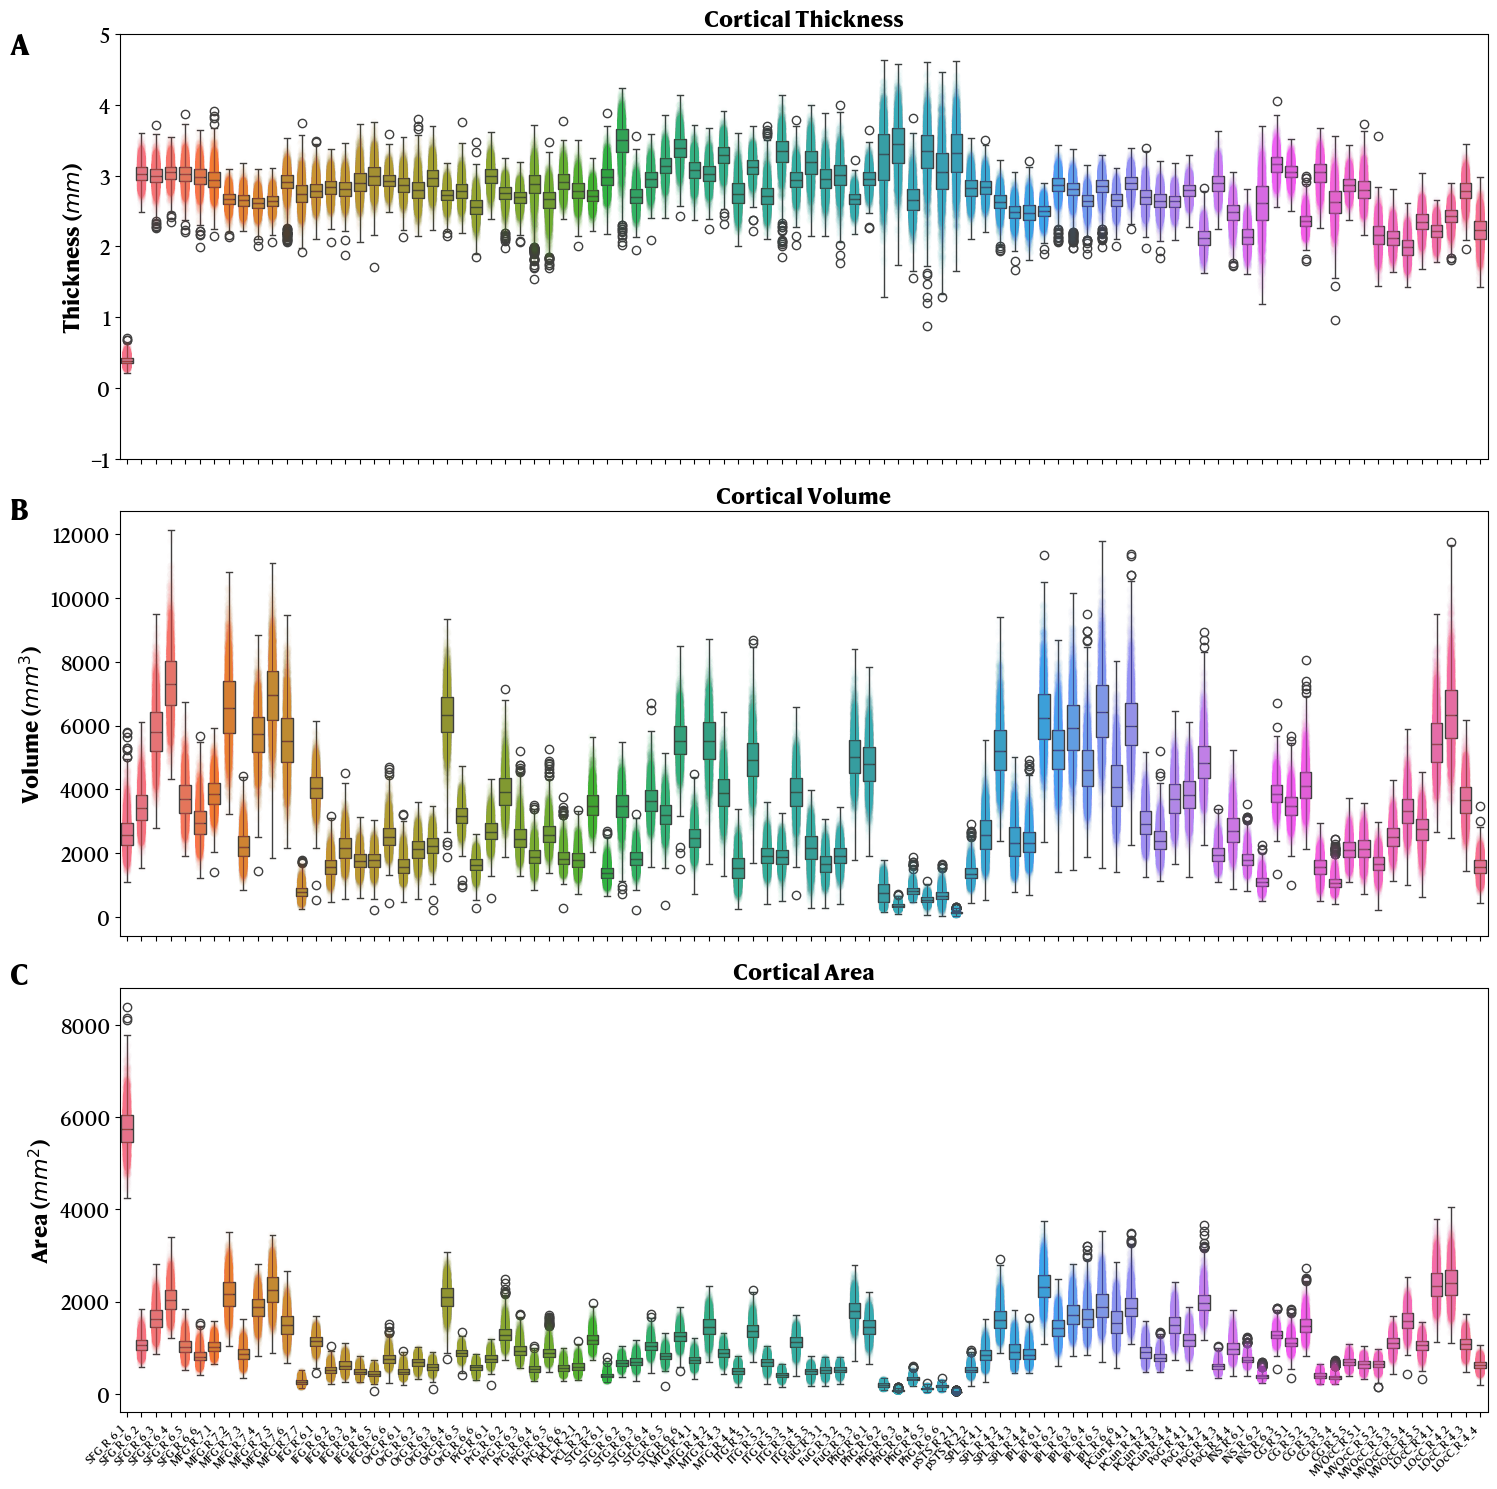

In [29]:
# Plotting the distribution of thickness, volume and area for right hemisphere using a boxplot after QC.

fig, ax = plt.subplots(3, 1, figsize=(15, 15))

# Thickness.
thicknessbox = sns.boxplot(data=thickness_df_QCed.iloc[:, 1:], ax=ax[0], whis=3)
sns.stripplot(data=thickness_df_QCed.iloc[:, 1:], ax=ax[0], alpha=0.01, palette="husl")
ax[0].set_title("Cortical Thickness", fontsize=16, fontweight='bold')
ax[0].set_ylabel("Thickness ($mm$)", fontsize=16, fontweight='bold')
ax[0].figure.autofmt_xdate(rotation=45, ha='right')
ax[0].set_ylim(-1, 5)
ax[0].tick_params(axis='y', labelsize=14)

# Volume.
volumebox = sns.boxplot(data=volume_df_QCed.iloc[:, 1:], ax=ax[1], whis=3)
sns.stripplot(data=volume_df_QCed.iloc[:, 1:], ax=ax[1], alpha=0.01, palette="husl")
ax[1].set_title("Cortical Volume", fontsize=16, fontweight='bold')
ax[1].set_ylabel("Volume ($mm^3$)", fontsize=16, fontweight='bold')
ax[1].figure.autofmt_xdate(rotation=45, ha='right')
ax[1].tick_params(axis='y', labelsize=14)

# Area.
areabox = sns.boxplot(data=area_df_QCed.iloc[:, 1:], ax=ax[2], whis=3)
sns.stripplot(data=area_df_QCed.iloc[:, 1:], ax=ax[2], alpha=0.01, palette="husl")
ax[2].set_title("Cortical Area", fontsize=16, fontweight='bold')
ax[2].set_ylabel("Area ($mm^2$)", fontsize=16, fontweight='bold')
ax[2].figure.autofmt_xdate(rotation=45, ha='right')
ax[2].tick_params(axis='y', labelsize=14)
ax[2].tick_params(axis='x', labelsize=8)

txt = r"$\bf{"+str("Figure\ 6.")+"}$" + "Distribution of cortical thickness, volume and area for right hemisphere for each ROIs after outlier removal (subjects with values over or under 3 * IQR range) in the ABCD cohort. " + \
        r"$\bf{"+"A."+"}$" + "Cortical Thickness. " + r"$\bf{"+"B."+"}$" + "Cortical Volume. " + r"$\bf{"+"C."+"}$" + "Cortical Area."

#plt.figtext(0.5, -0.015, txt, wrap=True, horizontalalignment='center', fontsize=12)

# Add label to subplots.
plt.gcf().text(0.005, 0.96, "A", fontsize=20, fontweight='bold')
plt.gcf().text(0.005, 0.65, "B", fontsize=20, fontweight='bold')
plt.gcf().text(0.005, 0.34, "C", fontsize=20, fontweight='bold')

# Save the plot.
plt.tight_layout()
plt.savefig(f"{output_dir}/ABCD_cortical_thickness_volume_area_boxplot_right_hemi_QCed.png", dpi=300, bbox_inches='tight')

In [30]:
# Fetch all subjects that were excluded in both hemispheres and in subcortical data.
excluded_subs = excluded_subs_left.union(excluded_subs_right).union(ids)
print(f"Number of subjects excluded in both hemispheres and subcortical data: {len(excluded_subs)}")

# Save the IDs of the excluded subjects in a text file.
with open(f"{output_dir}/ABCD_excluded_subjects.txt", "w") as f:
    for sub in excluded_subs:
        f.write(f"{sub}\n")

Number of subjects excluded in both hemispheres and subcortical data: 189


In [45]:
len(np.unique(ids_to_exclude))

189